In [1]:
# 因子有效性检验
import pandas as pd

In [2]:
# 先获取上一步处理完的数据
factor = pd.read_hdf('/Users/syesw/Desktop/single_factor_research/temp/hs300_alpha1_factor.h5', key='data')
price = pd.read_hdf('/Users/syesw/Desktop/single_factor_research/temp/hs300_price.h5', key='data')

In [3]:
# 我自定义了三个工具，分别为中位数绝对偏差去极值，去市值中心化与标准化
from utils.tool import mad
from utils.tool import market_cap_neutralize
from utils.tool import stand

<Axes: xlabel='date,asset'>

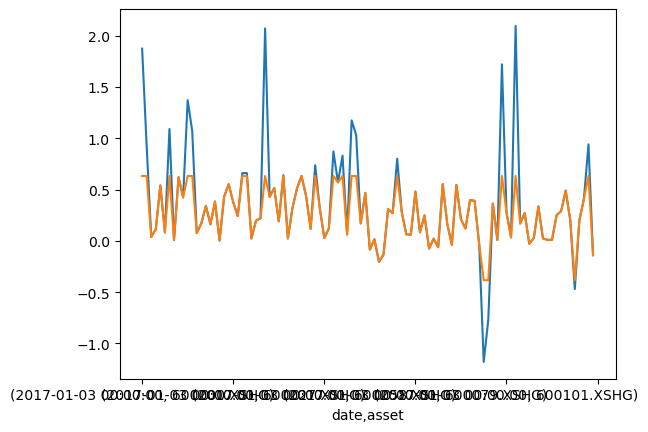

In [4]:
# 因为我的alpha1是直接计算得来的，所以不会有偏差，这里用米筐获取的EPS财务因子为例展示下数据预处理
EPS_factor = pd.read_hdf('/Users/syesw/Desktop/single_factor_research/temp/20170103-20180103-EPS-factor.h5', key='price')
Marketcap_factor = pd.read_hdf('/Users/syesw/Desktop/single_factor_research/temp/20170103-20180103-marketcap-factor.h5', key='price')

# 把异常值拉回正常区间而不是直接删除
EPS_factor['basic_earnings_per_share'][:100].plot()
EPS_factor['basic_earnings_per_share'] = mad(EPS_factor['basic_earnings_per_share'])
EPS_factor['basic_earnings_per_share'][:100].plot()

In [5]:
# 比市值拉出来，进行去市值中心化处理
merged_df = pd.merge(Marketcap_factor, EPS_factor, left_index=True, right_index=True, how='inner')
merged_df

market_cap  basic_earnings_per_share
date       order_book_id asset                                              
2017-01-03 600000.XSHG   600000.XSHG  3.523780e+11                  0.632139
                         600004.XSHG  3.523780e+11                  0.632139
                         600005.XSHG  3.523780e+11                  0.037000
                         600006.XSHG  3.523780e+11                  0.113600
                         600007.XSHG  3.523780e+11                  0.540000
...                                            ...                       ...
2018-01-03 603999.XSHG   603993.XSHG  4.498560e+09                  0.090000
                         603996.XSHG  4.498560e+09                  0.233300
                         603997.XSHG  4.498560e+09                  0.350000
                         603998.XSHG  4.498560e+09                  0.170000
                         603999.XSHG  4.498560e+09                  0.092000

[332126311 rows x 2 columns]

In [6]:
# 去市值化处理，具体实现可以看看我写的函数
# EPS_facor_after_neutralize = market_cap_neutralize(merged_df, 'market_cap', 'basic_earnings_per_share').drop(columns=['market_cap','basic_earnings_per_share'])

In [8]:
# 标准化处理,这里把我Alpha1的因子给标准化了
factor['Alpha1'] = stand(factor['Alpha1'])
factor.to_hdf('/Users/syesw/Desktop/single_factor_research/temp/hs300_alpha1_factor.h5', key='data', mode='w', complevel=9, complib='blosc')

In [10]:
# 原版alphalens已经停止维护，这个是开源维护的新版本alphalens（我一同上传了）
# 如果使用旧版alphalens，有关pandas/numpy的部分会报错，原因是因为当前multi index的处理方法与过去不一致

from new_alphalens import performance
from new_alphalens import plotting
from new_alphalens import tears
from new_alphalens import utils

In [12]:
# 计算股票的远期收益
factor_return = utils.get_clean_factor_and_forward_returns(factor, price)

Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [13]:
factor_return

1D        5D       10D    factor  \
date       asset                                                 
2010-01-08 000001.XSHE  0.000000 -0.051773  0.021236  0.133634   
           000002.XSHE -0.016430 -0.020296 -0.077302  0.311267   
           000009.XSHE -0.019521  0.015103  0.000904  0.962587   
           000012.XSHE -0.017357  0.048306 -0.001617  0.429688   
           000021.XSHE  0.036401  0.095089 -0.035668 -0.043999   
...                          ...       ...       ...       ...   
2021-12-17 601939.XSHG  0.000000  0.013735  0.005148  0.477057   
           601958.XSHG -0.019779 -0.038136 -0.032491  0.098107   
           601988.XSHG -0.003278 -0.003278 -0.003278  1.412590   
           601991.XSHG  0.006311  0.082011  0.022088  1.270483   
           601998.XSHG -0.002219  0.017650  0.019869  0.903376   

                        factor_quantile  
date       asset                         
2010-01-08 000001.XSHE                3  
           000002.XSHE                3  
           000009.XSHE                4  
           000012.XSHE                4  
           000021.XSHE                3  
...                                 ...  
2021-12-17 601939.XSHG                4  
           601958.XSHG                3  
           601988.XSHG                5  
           601991.XSHG                5  
           601998.XSHG                4  

[848852 rows x 5 columns]

In [15]:
# 计算IC
IC = performance.factor_information_coefficient(factor_return)
IC

,1D,5D,10D
date,,,
2010-01-08,0.020621,0.074383,0.170697
2010-01-11,0.095742,0.069563,0.160792
2010-01-12,0.048539,0.115487,0.178983
2010-01-13,-0.059980,0.122348,0.202372
2010-01-14,0.092436,0.210989,0.258754
...,...,...,...
2021-12-13,0.046271,0.472889,0.247435
2021-12-14,0.371983,0.538568,0.210839
2021-12-15,0.174927,0.420360,0.157575


array([<Axes: title={'center': '1D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>,
       <Axes: title={'center': '5D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>,
       <Axes: title={'center': '10D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>],
      dtype=object)

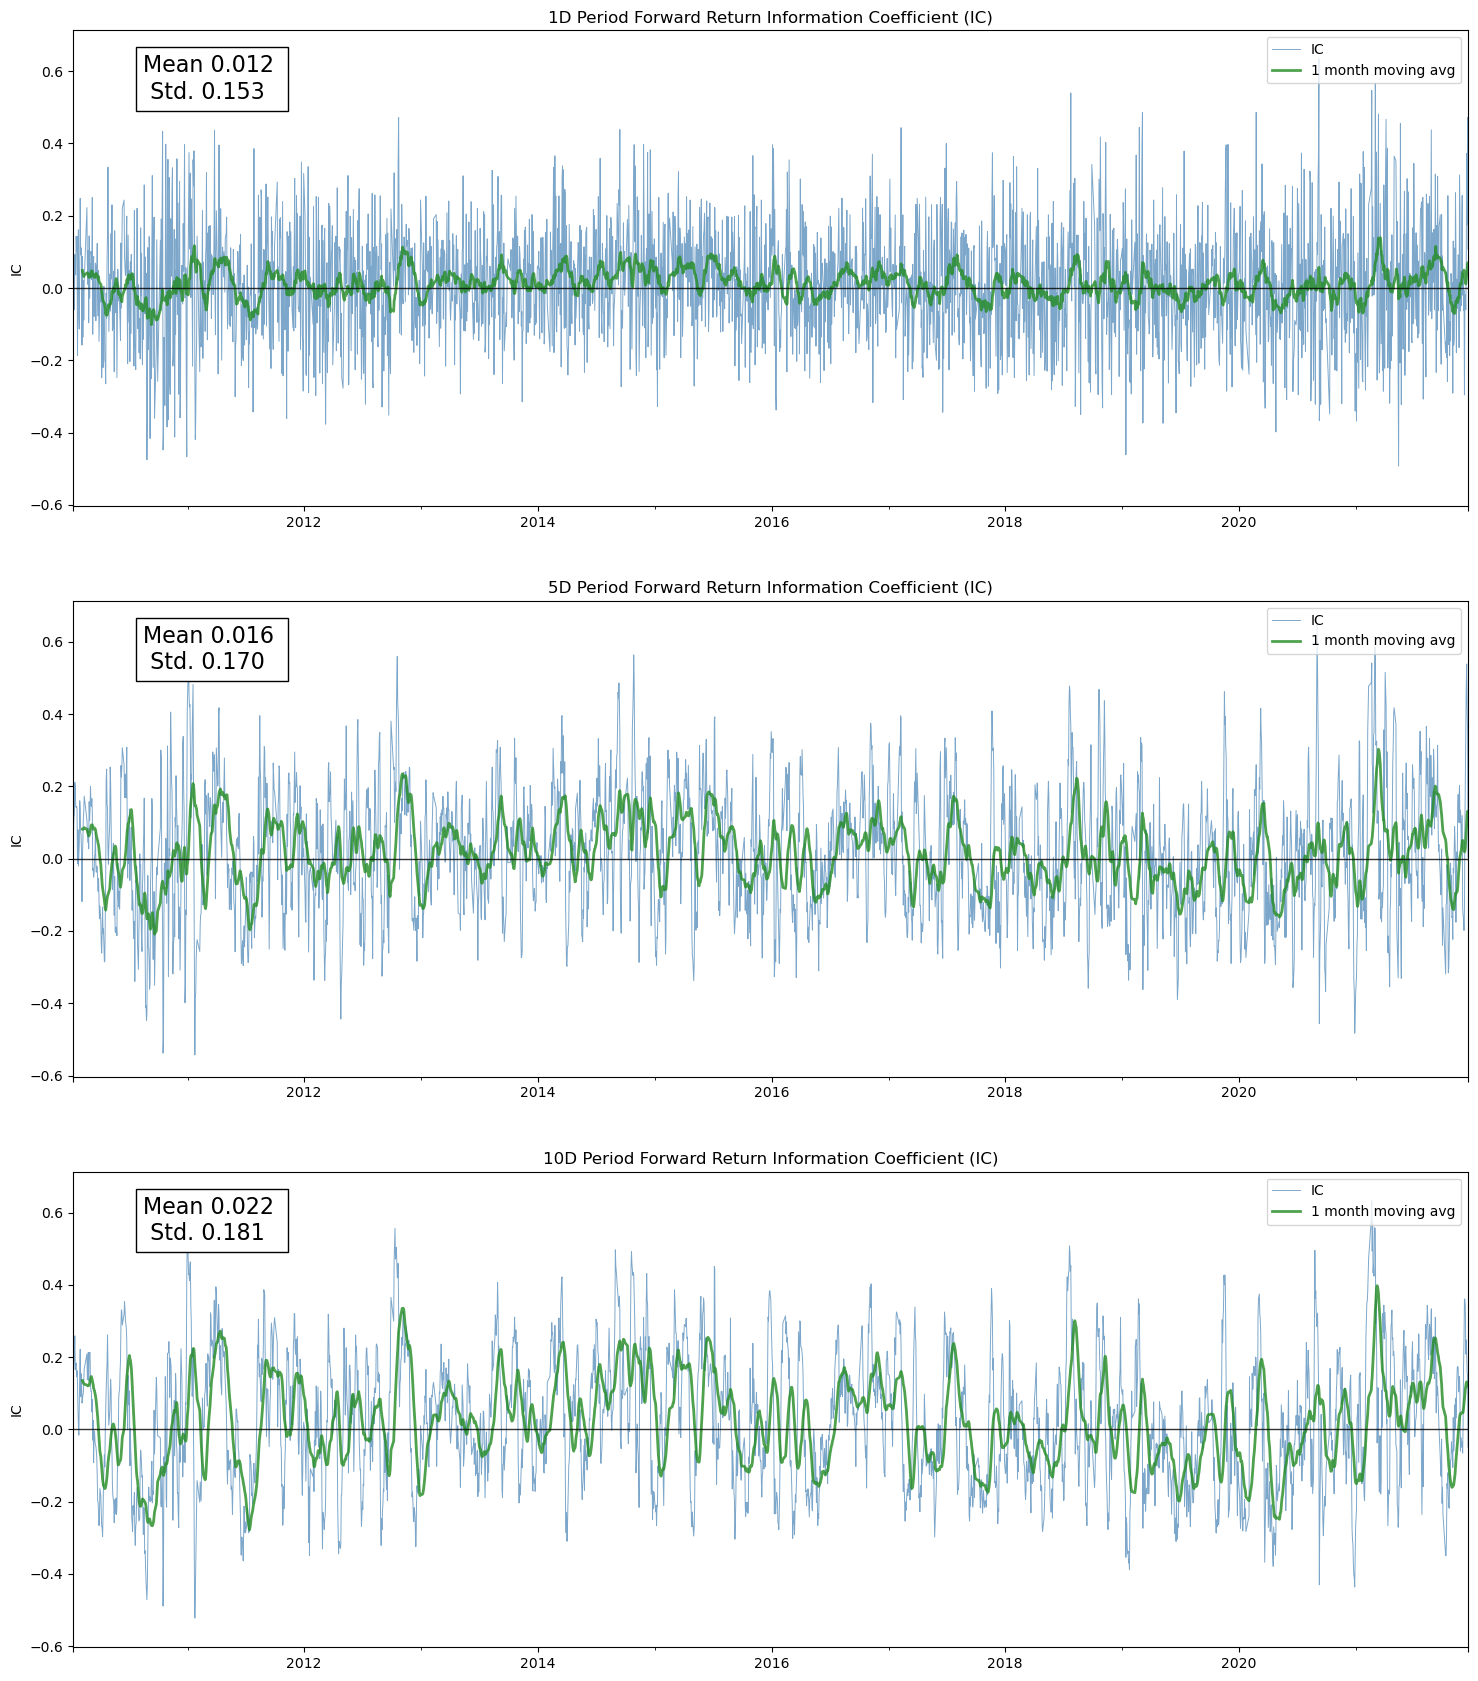

In [16]:
# 因子IC序列图
plotting.plot_ic_ts(IC)

array([<Axes: title={'center': '1D Period IC'}, xlabel='IC', ylabel='Count'>,
       <Axes: title={'center': '5D Period IC'}, xlabel='IC', ylabel='Count'>,
       <Axes: title={'center': '10D Period IC'}, xlabel='IC', ylabel='Count'>],
      dtype=object)

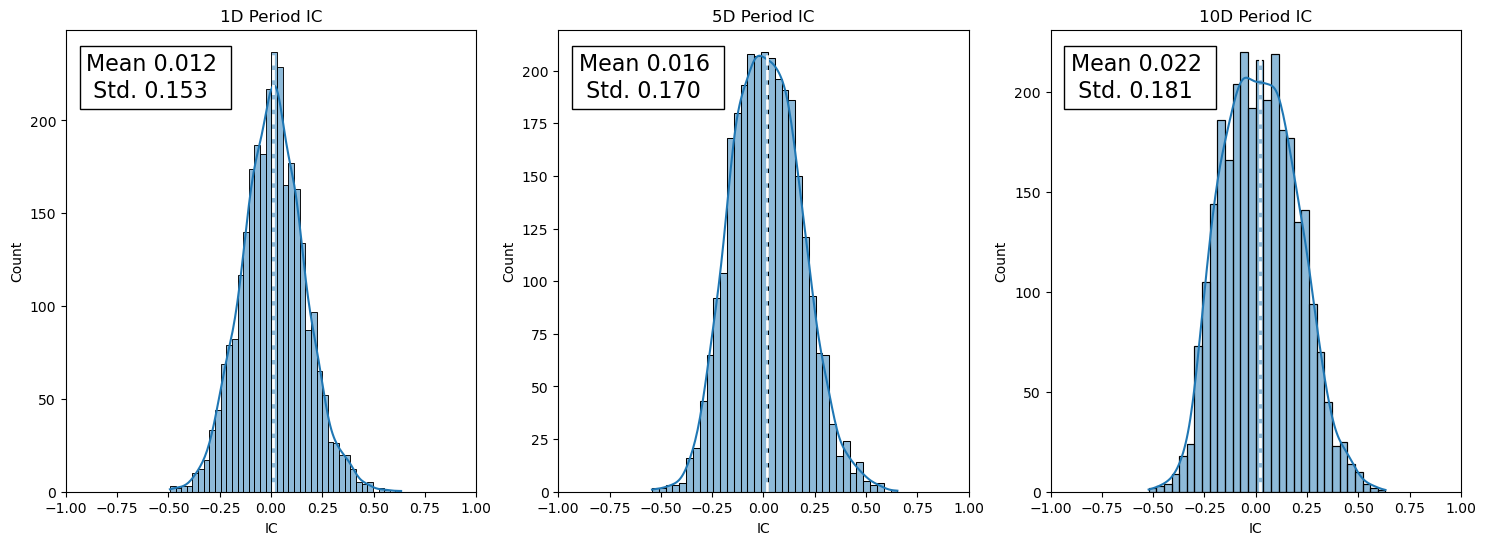

In [17]:
# 因子IC分布图
plotting.plot_ic_hist(IC)

In [18]:
# 一些统计数据
# 因子平均收益（注意是因子的收益不是股票的远期收益）
factor_mean_return = performance.factor_returns(factor_return).iloc[:,0].mean()

# mean and std
IC_mean = IC.iloc[:, 0].mean()
IC_std = IC.iloc[:, 0].std()

# IC > 0.02的概率
a = IC.iloc[:, 0]
percent = len(a[a>0.02])/len(a)

# IR信息比率
IR = IC_mean/IC_std

print("Factor mean return", factor_mean_return)
print("IC Mean:", IC_mean)
print("IC Std:", IC_std)
print("IC > 0.02:", percent)
print("IR:", IR)


Factor mean return 0.00016899584786871547
IC Mean: 0.01161076375727659
IC Std: 0.15261039455804937
IC > 0.02: 0.472270065449535
IR: 0.0760810807868014


Returns Analysis


,1D,5D,10D
Ann. alpha,0.044,0.041,0.038
beta,-0.009,-0.008,0.001
Mean Period Wise Return Top Quantile (bps),2.351,2.142,1.935
Mean Period Wise Return Bottom Quantile (bps),-1.375,-1.326,-1.272
Mean Period Wise Spread (bps),3.726,3.508,3.253


<Figure size 640x480 with 0 Axes>

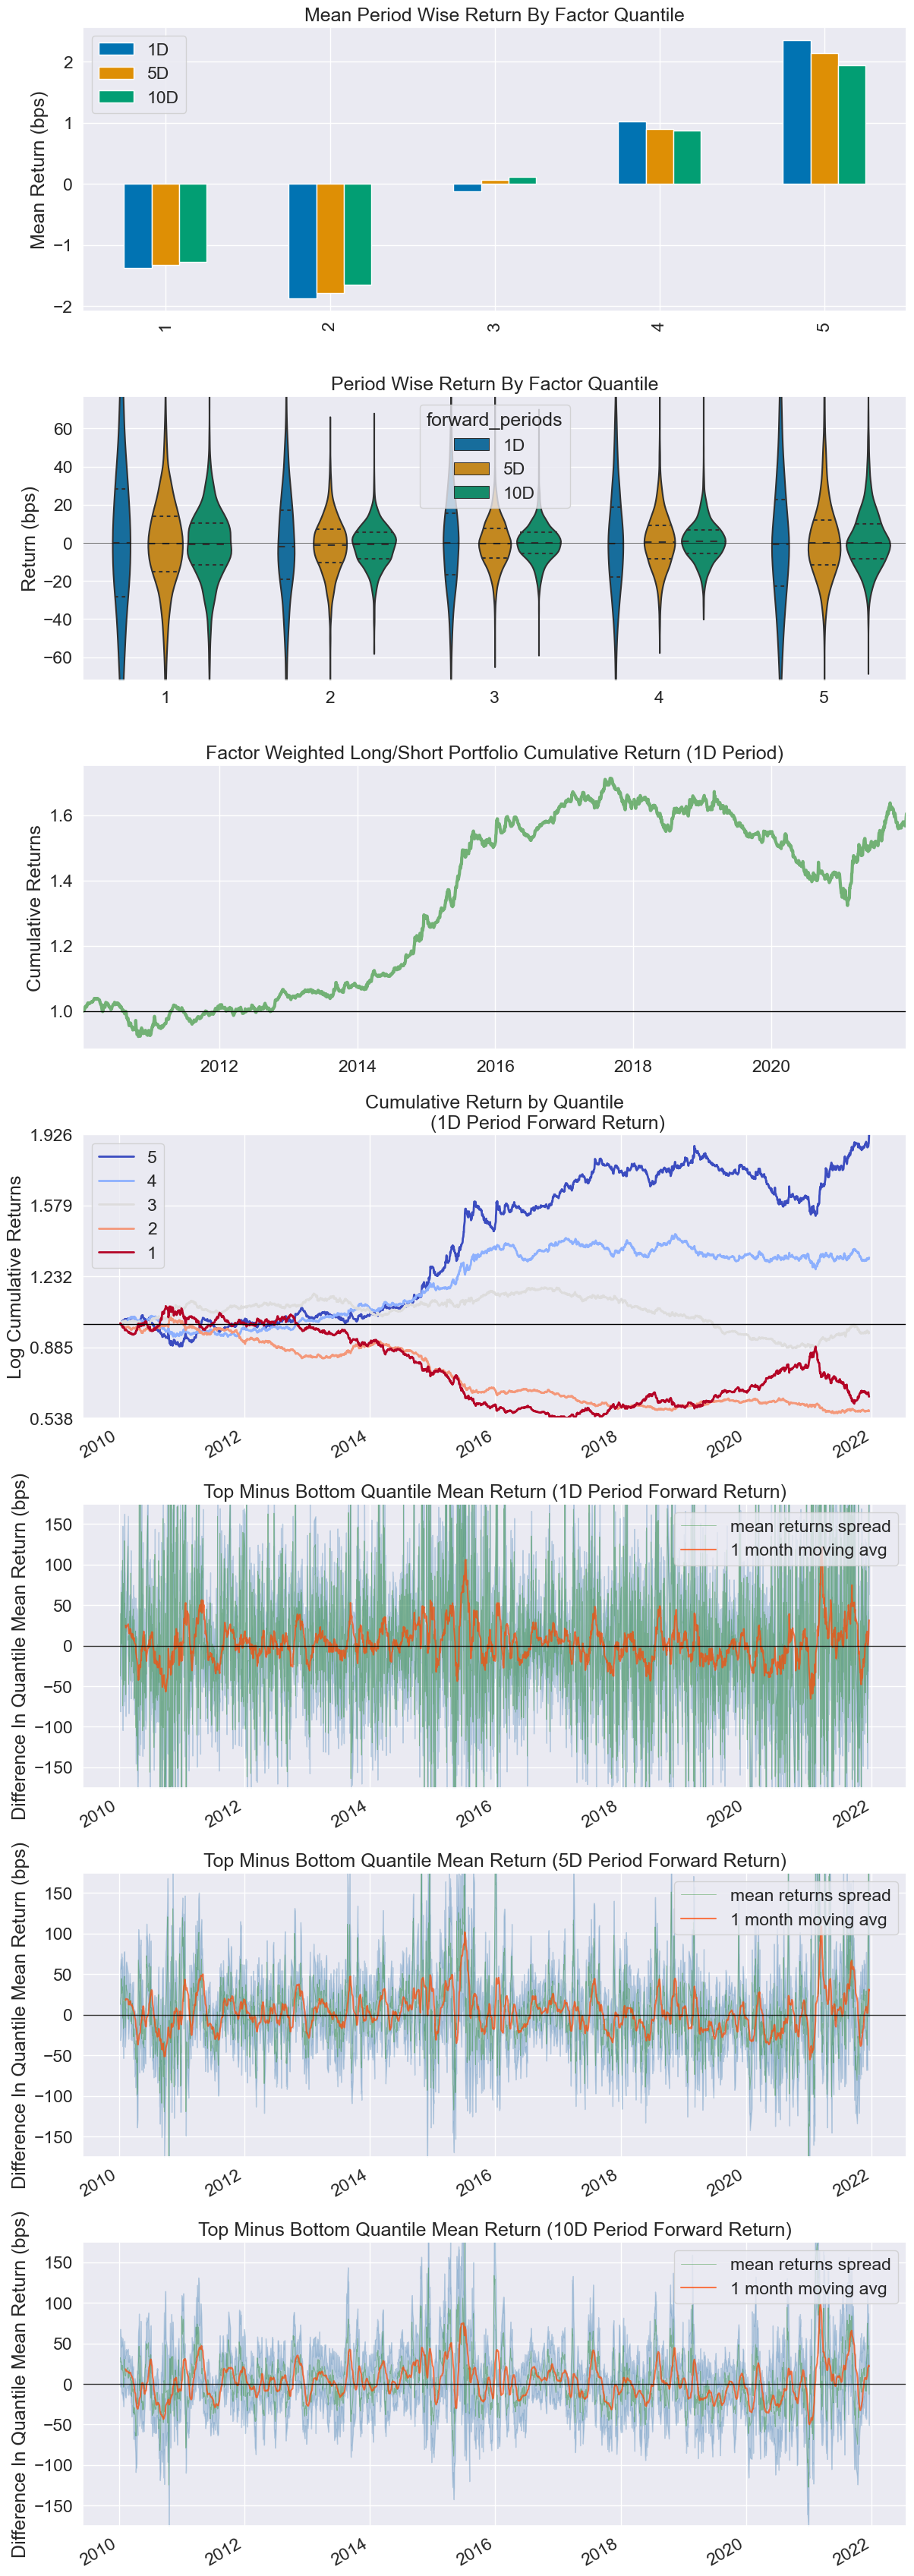

In [19]:
# 因子的收益率分析
tears.create_returns_tear_sheet(factor_return)